In [3]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [93]:
# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=0

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [94]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


In [95]:
train_x1

tensor([[ 1.1562e+00, -6.7676e-01, -2.9011e-02,  ..., -1.0559e+00,
         -1.4391e+00, -6.0677e-01],
        [-3.5220e-01,  1.6572e-01,  1.4609e+00,  ..., -1.6776e+00,
         -1.3760e-03,  7.8600e-01],
        [ 9.6538e-01, -3.3180e-01,  1.0211e+00,  ..., -1.2069e-01,
         -1.0751e+00, -3.9528e-01],
        ...,
        [-1.0532e+00,  2.7305e-01,  3.2043e-01,  ...,  2.4501e+00,
         -4.6602e-02, -4.2758e-01],
        [ 2.1007e-01, -4.2998e-02,  1.1864e+00,  ...,  6.7503e-01,
         -8.6875e-01,  4.5822e-01],
        [ 6.1372e-01, -8.2253e-02, -1.4422e-01,  ...,  6.7524e-01,
          2.2452e-02, -8.7104e-01]])

tensor(0.2283, dtype=torch.float64)

tensor(0.2145, dtype=torch.float64)

tensor(0.2181, dtype=torch.float64)

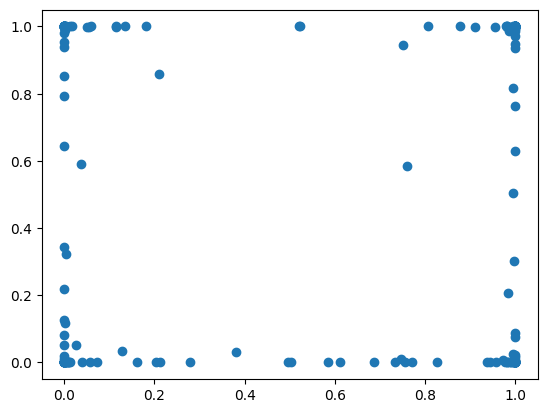

In [96]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

In [97]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [98]:
################## first step##################

#0.6,0.3
# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    sum_tGM=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,ga,lr=config["lambda1"],config["lambda2"],config["ga"],config["lr"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

     
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    
    config={
        "lambda1": tune.choice([0.005,0.01,0.05]),
        "lambda2": tune.choice([0.003]),
        "lr": tune.choice([0.7]),
        "ga": tune.choice([0.3,0.4,0.5])
    }
    #config={
    #    "lambda1": tune.choice([0.05,0.1,0.6]),
    #    "lambda2": tune.choice([0.0001,0.0002,0.0003, 0.0004,0.0005])
    #}

    result = tune.run(
        train_model,  
        config=config,
        num_samples=60)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,ga,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_30514_00000,TERMINATED,10.224.0.12:12148,0.5,0.05,0.003,0.7,1,13.4855,1.25933
train_model_30514_00001,TERMINATED,10.224.0.12:12704,0.3,0.005,0.003,0.7,1,13.7325,2.2971
train_model_30514_00002,TERMINATED,10.224.0.12:12706,0.3,0.05,0.003,0.7,1,16.2967,1.48675
train_model_30514_00003,TERMINATED,10.224.0.12:12708,0.4,0.01,0.003,0.7,1,15.7309,2.0638
train_model_30514_00004,TERMINATED,10.224.0.12:12710,0.5,0.05,0.003,0.7,1,16.1297,1.25933
train_model_30514_00005,TERMINATED,10.224.0.12:12712,0.3,0.01,0.003,0.7,1,15.588,2.1037
train_model_30514_00006,TERMINATED,10.224.0.12:12714,0.5,0.05,0.003,0.7,1,16.0042,1.25933
train_model_30514_00007,TERMINATED,10.224.0.12:12716,0.4,0.05,0.003,0.7,1,14.302,1.41713
train_model_30514_00008,TERMINATED,10.224.0.12:12718,0.3,0.05,0.003,0.7,1,15.5878,1.48675
train_model_30514_00009,TERMINATED,10.224.0.12:12720,0.4,0.005,0.003,0.7,1,14.3315,2.23296


Result for train_model_30514_00000:
  date: 2022-10-12_17-28-26
  done: false
  experiment_id: b6de32fe4a6248b2a3c9150aa0245c64
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2593268871307373
  node_ip: 10.224.0.12
  pid: 12148
  time_since_restore: 13.485540390014648
  time_this_iter_s: 13.485540390014648
  time_total_s: 13.485540390014648
  timestamp: 1665566906
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '30514_00000'
  warmup_time: 0.003974437713623047
  
Result for train_model_30514_00000:
  date: 2022-10-12_17-28-26
  done: true
  experiment_id: b6de32fe4a6248b2a3c9150aa0245c64
  experiment_tag: 0_ga=0.5000,lambda1=0.0500,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2593268871307373
  node_ip: 10.224.0.12
  pid: 12148
  time_since_restore: 13.485540390014648
  time_this_iter_s: 13.485540390014648
  time_total_s: 13.485540390014648
  timestamp: 1665566906
  tim

Result for train_model_30514_00022:
  date: 2022-10-12_17-28-32
  done: false
  experiment_id: 02ded3b89c1343128b9034e9b36a403a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2593268871307373
  node_ip: 10.224.0.12
  pid: 12746
  time_since_restore: 14.270188331604004
  time_this_iter_s: 14.270188331604004
  time_total_s: 14.270188331604004
  timestamp: 1665566912
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '30514_00022'
  warmup_time: 0.007361412048339844
  
Result for train_model_30514_00009:
  date: 2022-10-12_17-28-32
  done: true
  experiment_id: 393d84dbc5ea444dadd67b4d995c2917
  experiment_tag: 9_ga=0.4000,lambda1=0.0050,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.2329598665237427
  node_ip: 10.224.0.12
  pid: 12720
  time_since_restore: 14.331493139266968
  time_this_iter_s: 14.331493139266968
  time_total_s: 14.331493139266968
  timestamp: 1665566912
  tim

Result for train_model_30514_00005:
  date: 2022-10-12_17-28-33
  done: true
  experiment_id: 1abe672af16741bbbacf405068afafc2
  experiment_tag: 5_ga=0.3000,lambda1=0.0100,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.103701281547546
  node_ip: 10.224.0.12
  pid: 12712
  time_since_restore: 15.587969303131104
  time_this_iter_s: 15.587969303131104
  time_total_s: 15.587969303131104
  timestamp: 1665566913
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '30514_00005'
  warmup_time: 0.00668025016784668
  
Result for train_model_30514_00025:
  date: 2022-10-12_17-28-33
  done: false
  experiment_id: 4d2353318ada4c26a2a7bb851cdd2821
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.103701281547546
  node_ip: 10.224.0.12
  pid: 12753
  time_since_restore: 15.627943992614746
  time_this_iter_s: 15.627943992614746
  time_total_s: 15.627943992614746
  timestamp: 1665566913
  timest

Result for train_model_30514_00028:
  date: 2022-10-12_17-28-33
  done: false
  experiment_id: 24da7620182b4216a3b4775f4b14407c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2593268871307373
  node_ip: 10.224.0.12
  pid: 12758
  time_since_restore: 15.978312015533447
  time_this_iter_s: 15.978312015533447
  time_total_s: 15.978312015533447
  timestamp: 1665566913
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '30514_00028'
  warmup_time: 0.016393184661865234
  
Result for train_model_30514_00028:
  date: 2022-10-12_17-28-33
  done: true
  experiment_id: 24da7620182b4216a3b4775f4b14407c
  experiment_tag: 28_ga=0.5000,lambda1=0.0500,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2593268871307373
  node_ip: 10.224.0.12
  pid: 12758
  time_since_restore: 15.978312015533447
  time_this_iter_s: 15.978312015533447
  time_total_s: 15.978312015533447
  timestamp: 1665566913
  ti

Result for train_model_30514_00033:
  date: 2022-10-12_17-28-44
  done: true
  experiment_id: 5201e7b541a3431d8ed1c39788d11b10
  experiment_tag: 33_ga=0.5000,lambda1=0.0050,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.142047882080078
  node_ip: 10.224.0.12
  pid: 12722
  time_since_restore: 13.243807315826416
  time_this_iter_s: 13.243807315826416
  time_total_s: 13.243807315826416
  timestamp: 1665566924
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '30514_00033'
  warmup_time: 0.004418373107910156
  
Result for train_model_30514_00034:
  date: 2022-10-12_17-28-44
  done: false
  experiment_id: 5374900c574b40c7a4f264c25059fa4b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.142047882080078
  node_ip: 10.224.0.12
  pid: 12704
  time_since_restore: 13.15344786643982
  time_this_iter_s: 13.15344786643982
  time_total_s: 13.15344786643982
  timestamp: 1665566924
  timeste

Result for train_model_30514_00042:
  date: 2022-10-12_17-28-45
  done: false
  experiment_id: 564348cb6de449e1b7a669ec9712cd92
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0310104131698608
  node_ip: 10.224.0.12
  pid: 12756
  time_since_restore: 12.733940362930298
  time_this_iter_s: 12.733940362930298
  time_total_s: 12.733940362930298
  timestamp: 1665566925
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '30514_00042'
  warmup_time: 0.008699893951416016
  
Result for train_model_30514_00042:
  date: 2022-10-12_17-28-45
  done: true
  experiment_id: 564348cb6de449e1b7a669ec9712cd92
  experiment_tag: 42_ga=0.5000,lambda1=0.0100,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0310104131698608
  node_ip: 10.224.0.12
  pid: 12756
  time_since_restore: 12.733940362930298
  time_this_iter_s: 12.733940362930298
  time_total_s: 12.733940362930298
  timestamp: 1665566925
  ti

Result for train_model_30514_00045:
  date: 2022-10-12_17-28-46
  done: false
  experiment_id: 7039ebba037c42728b718828173eccb7
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0310104131698608
  node_ip: 10.224.0.12
  pid: 12724
  time_since_restore: 13.451172351837158
  time_this_iter_s: 13.451172351837158
  time_total_s: 13.451172351837158
  timestamp: 1665566926
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '30514_00045'
  warmup_time: 0.012209653854370117
  
Result for train_model_30514_00045:
  date: 2022-10-12_17-28-46
  done: true
  experiment_id: 7039ebba037c42728b718828173eccb7
  experiment_tag: 45_ga=0.5000,lambda1=0.0100,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0310104131698608
  node_ip: 10.224.0.12
  pid: 12724
  time_since_restore: 13.451172351837158
  time_this_iter_s: 13.451172351837158
  time_total_s: 13.451172351837158
  timestamp: 1665566926
  ti

Result for train_model_30514_00050:
  date: 2022-10-12_17-28-47
  done: false
  experiment_id: 964ab82d8b074c72911694fd15166295
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2593268871307373
  node_ip: 10.224.0.12
  pid: 12730
  time_since_restore: 14.307308673858643
  time_this_iter_s: 14.307308673858643
  time_total_s: 14.307308673858643
  timestamp: 1665566927
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '30514_00050'
  warmup_time: 0.010286808013916016
  
Result for train_model_30514_00050:
  date: 2022-10-12_17-28-47
  done: true
  experiment_id: 964ab82d8b074c72911694fd15166295
  experiment_tag: 50_ga=0.5000,lambda1=0.0500,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2593268871307373
  node_ip: 10.224.0.12
  pid: 12730
  time_since_restore: 14.307308673858643
  time_this_iter_s: 14.307308673858643
  time_total_s: 14.307308673858643
  timestamp: 1665566927
  ti

2022-10-12 17:28:48,026	INFO tune.py:758 -- Total run time: 37.15 seconds (36.76 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
30514_00000          1.259327         13.485540  True            None   
30514_00001          2.297099         13.732524  True            None   
30514_00002          1.486752         16.296698  True            None   
30514_00003          2.063801         15.730872  True            None   
30514_00004          1.259327         16.129726  True            None   
30514_00005          2.103701         15.587969  True            None   
30514_00006          1.259327         16.004210  True            None   
30514_00007          1.417129         14.302018  True            None   
30514_00008          1.486752         15.587830  True            None   
30514_00009          2.232960         14.331493  True            None   
30514_00010          2.297099         13.585363  True            N

In [99]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.2593268871307373


{'lambda1': 0.05, 'lambda2': 0.003, 'lr': 0.7, 'ga': 0.5}

In [87]:
################## second step##################
################## training stage ##################

# set hyperparamters
# final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda=result.get_best_config('my_test_BCE_loss',mode='max')
lambda1,lambda2,lr,ga=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"],final_lambda["ga"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.0301, grad_fn=<AddBackward0>)

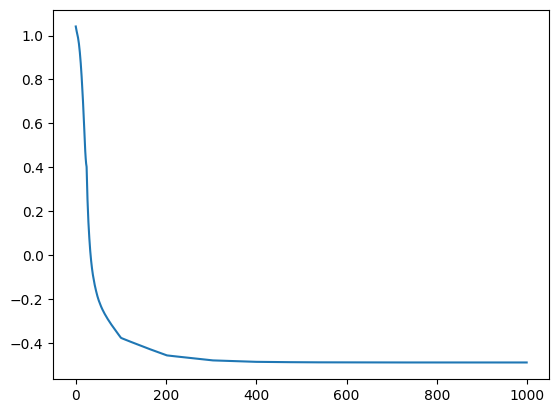

In [88]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [91]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.0896e+00, -5.2976e-01, -9.4088e-01, -1.1461e+00, -1.1608e-07,
         -7.5580e-01, -6.7365e-01, -1.2499e+00, -5.2252e-01,  1.9105e-01,
         -2.9841e-01, -1.2376e-01, -5.2119e-08,  1.2178e+00, -1.5354e-08,
          7.8726e-02, -2.4284e-01, -6.4130e-01,  3.1422e-01, -2.8658e-07,
          4.0878e-01, -1.9351e-07, -2.1059e-01,  3.1660e-01,  6.1491e-01,
          2.9689e-08, -1.7279e+00, -9.6818e-01,  1.9265e-07, -1.8544e-01,
         -3.7634e-01,  7.0404e-08,  1.3983e+00, -2.7242e-07, -7.0975e-08,
         -2.9532e-01, -2.2286e-07, -5.1578e-08,  9.4308e-08, -9.7503e-02,
         -6.1781e-08, -2.0551e-08,  2.2693e-07, -2.4273e-07,  1.8407e+00,
         -5.4336e-01,  1.0421e+00, -1.8374e-01, -4.3080e-01,  1.1567e-01,
          4.1804e-08, -8.3812e-03,  2.5795e-01,  3.4351e-02,  6.4989e-01,
          1.4829e+00, -6.5925e-08,  5.1860e-01,  2.7530e-07, -1.8160e-01,
          1.1082e+00, -3.6319e-01, -2.6610e+00, -3.4575e-01, -8.8160e-08,
         -5.8940e-01, -1.2671e-01, -4.

tensor([[-1.0896e+00, -5.2976e-01, -9.4088e-01, -1.1461e+00, -1.1608e-07,
         -7.5580e-01, -6.7365e-01, -1.2499e+00, -5.2252e-01,  1.9105e-01,
         -2.9841e-01, -1.2376e-01, -5.2119e-08,  1.2178e+00, -1.5354e-08,
          7.8726e-02, -2.4284e-01, -6.4130e-01,  3.1422e-01, -2.8658e-07,
          4.0878e-01, -1.9351e-07, -2.1059e-01,  3.1660e-01,  6.1491e-01,
          2.9689e-08, -1.7279e+00, -9.6818e-01,  1.9265e-07, -1.8544e-01,
         -3.7634e-01,  7.0404e-08,  1.3983e+00, -2.7242e-07, -7.0975e-08,
         -2.9532e-01, -2.2286e-07, -5.1578e-08,  9.4308e-08, -9.7503e-02,
         -6.1781e-08, -2.0551e-08,  2.2693e-07, -2.4273e-07,  1.8407e+00,
         -5.4336e-01,  1.0421e+00, -1.8374e-01, -4.3080e-01,  1.1567e-01,
          4.1804e-08, -8.3812e-03,  2.5795e-01,  3.4351e-02,  6.4989e-01,
          1.4829e+00, -6.5925e-08,  5.1860e-01,  2.7530e-07, -1.8160e-01,
          1.1082e+00, -3.6319e-01, -2.6610e+00, -3.4575e-01, -8.8160e-08,
         -5.8940e-01, -1.2671e-01, -4.

tensor([[-1.3352e+00, -5.8735e-01, -9.3951e-01, -1.4364e+00,  3.1077e-09,
         -1.0896e+00, -7.5566e-01, -1.3774e+00, -6.3784e-01,  2.1762e-01,
         -5.5230e-01, -5.7427e-02,  6.1147e-09,  1.4087e+00,  1.3699e-08,
          1.4468e-01, -3.8431e-01, -9.5646e-01,  4.4431e-01, -2.2376e-08,
          5.6707e-01,  2.1051e-08, -3.9165e-01,  5.4358e-01,  8.0148e-01,
          1.4787e-09, -1.9636e+00, -1.2069e+00, -7.3486e-09, -3.6605e-01,
         -5.6619e-01,  5.5637e-09,  1.6007e+00, -1.7045e-08,  1.1926e-08,
         -4.9681e-01, -1.7622e-09,  1.4001e-09,  7.0860e-09, -2.0395e-01,
         -1.6559e-08, -1.6486e-08, -1.2864e-09, -1.4108e-07,  2.1225e+00,
         -7.7116e-01,  1.2783e+00, -3.9782e-01, -6.1263e-01,  2.2938e-01,
          3.0640e-08, -6.2297e-02,  4.4877e-01,  1.1746e-01,  9.1629e-01,
          1.7182e+00,  2.0550e-10,  6.7592e-01,  1.3984e-08, -3.5351e-01,
          1.3303e+00, -5.7227e-01, -3.0271e+00, -5.4572e-01, -2.6425e-08,
         -7.6764e-01, -2.7006e-01, -7.

In [90]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[41, 10],
       [18, 51]])

0.7391304347826086

0.803921568627451

0.7666666666666667

0.8360655737704918

0.7846153846153846

In [72]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[18,  0],
       [ 4, 18]])

0.8181818181818182

1.0

array([[11,  4],
       [ 8, 17]])

0.68

0.7333333333333333

array([[14,  4],
       [ 1, 21]])

0.9545454545454546

0.7777777777777778

In [73]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.27672553e-01, -1.67554453e-01, -2.14573085e-01,
        -1.36581168e-01, -2.32804254e-01, -2.04818502e-01,
        -1.40707284e-01, -1.40264958e-01, -1.87078238e-01,
         1.70426950e-01, -3.23590434e-08, -2.15295739e-02,
         9.58251931e-08, -1.56363647e-03,  9.19487633e-08,
         6.72728433e-08, -2.80221872e-08,  3.08745278e-08,
         8.27752586e-08, -2.82386514e-09, -7.29563854e-10,
         5.63003546e-08, -9.13191869e-08,  8.02613513e-08,
         5.14643652e-08,  1.07066363e-07, -1.26061877e-07,
        -7.16024360e-08, -1.95272989e-07,  1.03193166e-07,
         9.87167610e-08,  1.01705936e-07, -3.46384290e-08,
        -1.15163887e-08,  6.31455066e-08, -7.81039020e-08,
         8.01822964e-08, -4.34887220e-08, -3.50504372e-08,
        -6.41697468e-08, -4.13564258e-08,  2.09039950e-08,
        -2.88071682e-08, -9.72892735e-08, -2.87454558e-08,
        -5.46049499e-08,  5.23460990e-08,  1.41825911e-08,
         4.87072498e-08, -1.46572788e-07, -9.27781016e-0

array([[-1.27672553e-01, -1.67554453e-01, -2.14573085e-01,
        -1.36581168e-01, -2.32804254e-01, -2.04818502e-01,
        -1.40707284e-01, -1.40264958e-01, -1.87078238e-01,
         1.70426950e-01, -3.23590434e-08, -2.15295739e-02,
         9.58251931e-08, -1.56363647e-03,  9.19487633e-08,
         6.72728433e-08, -2.80221872e-08,  3.08745278e-08,
         8.27752586e-08, -2.82386514e-09, -7.29563854e-10,
         5.63003546e-08, -9.13191869e-08,  8.02613513e-08,
         5.14643652e-08,  1.07066363e-07, -1.26061877e-07,
        -7.16024360e-08, -1.95272989e-07,  1.03193166e-07,
         9.87167610e-08,  1.01705936e-07, -3.46384290e-08,
        -1.15163887e-08,  6.31455066e-08, -7.81039020e-08,
         8.01822964e-08, -4.34887220e-08, -3.50504372e-08,
        -6.41697468e-08, -4.13564258e-08,  2.09039950e-08,
        -2.88071682e-08, -9.72892735e-08, -2.87454558e-08,
        -5.46049499e-08,  5.23460990e-08,  1.41825911e-08,
         4.87072498e-08, -1.46572788e-07, -9.27781016e-0

array([[-1.27672553e-01, -1.67554453e-01, -2.14573085e-01,
        -1.36581168e-01, -2.32804254e-01, -2.04818502e-01,
        -1.40707284e-01, -1.40264958e-01, -1.87078238e-01,
         1.70426950e-01, -3.23590434e-08, -2.15295739e-02,
         9.58251931e-08, -1.56363647e-03,  9.19487633e-08,
         6.72728433e-08, -2.80221872e-08,  3.08745278e-08,
         8.27752586e-08, -2.82386514e-09, -7.29563854e-10,
         5.63003546e-08, -9.13191869e-08,  8.02613513e-08,
         5.14643652e-08,  1.07066363e-07, -1.26061877e-07,
        -7.16024360e-08, -1.95272989e-07,  1.03193166e-07,
         9.87167610e-08,  1.01705936e-07, -3.46384290e-08,
        -1.15163887e-08,  6.31455066e-08, -7.81039020e-08,
         8.01822964e-08, -4.34887220e-08, -3.50504372e-08,
        -6.41697468e-08, -4.13564258e-08,  2.09039950e-08,
        -2.88071682e-08, -9.72892735e-08, -2.87454558e-08,
        -5.46049499e-08,  5.23460990e-08,  1.41825911e-08,
         4.87072498e-08, -1.46572788e-07, -9.27781016e-0

In [74]:
threshold=0.1
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.12767255, -0.16755445, -0.21457309, -0.13658117, -0.23280425,
        -0.2048185 , -0.14070728, -0.14026496, -0.18707824,  0.17042695,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 71])

11

In [69]:
index=np.nonzero(model_1_weight)[1]
beta=np.array(beta_1)
trueindex=np.where(beta!=0)[0]
trueindex=trueindex.tolist()
trueindex=set(trueindex)
TP=len(trueindex.intersection(index))
FP=len(np.setdiff1d(index,trueindex))
FN=len(trueindex)-TP
TN=p-len(trueindex)-FP
vsSEN=TP/(TP+FN)#vsSEN.
vsSPE=TN/(TN+FP)#vsSPE
vsSEN
vsSPE
math.sqrt(vsSEN*vsSPE)#vsGM
vsMR=(FP+FN)/(TP+FN+TN+FP)#vsMR
1-vsMR#vsCCR

1.0

0.8777777777777778

0.9368979548370131

0.89